In [1]:
import pandas as pd
import os
import numpy as np

# import dask.dataframe as dd
# from dask import delayed
from fastparquet import ParquetFile
import glob
# from fnmatch import fnmatch

import pyarrow.parquet as pq

from pyspark.sql import SparkSession
from pyspark.sql import functions as psf

import duckdb

from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px


In [2]:
# change memory allocation for pyarrow
# os.environ['PYARROW_MEMORY_POOL_MAX_CHUNKSIZE'] = '3000000000'
# os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
# os.environ['PYSPARK_PYTHON'] = sys.executable

## Get the path of all files

In [3]:
os.getcwd()

'c:\\Users\\milan\\OneDrive - MUNI\\VŠ\\PhD\\Zahraniční stáž\\Work\\HeiGIT_notebooks\\analysis\\ai-assisted-osm-mapping-stats\\notebooks-contributions'

In [4]:
os.chdir("..")
home_dir = os.getcwd()
parquet_dir_node = os.path.join(home_dir, r"oshdb-contributions-parquet-data\type=node")
parquet_dir = os.path.join(home_dir, r"oshdb-contributions-parquet-data")
duckdb_dir = os.path.join(home_dir, r"notebooks-contributions\duckdb")
test_dir = os.path.join(home_dir, r"oshdb-contributions-parquet-data\type=node\year=2023")


In [5]:
files = glob.glob(f'{parquet_dir}\\**\\*.parquet', recursive=True)
files


['c:\\Users\\milan\\OneDrive - MUNI\\VŠ\\PhD\\Zahraniční stáž\\Work\\HeiGIT_notebooks\\analysis\\ai-assisted-osm-mapping-stats\\oshdb-contributions-parquet-data\\type=node\\year=2018\\contribs-40abae66-9607-4276-8d89-ab3f9ca96f91.parquet',
 'c:\\Users\\milan\\OneDrive - MUNI\\VŠ\\PhD\\Zahraniční stáž\\Work\\HeiGIT_notebooks\\analysis\\ai-assisted-osm-mapping-stats\\oshdb-contributions-parquet-data\\type=node\\year=2018\\contribs-c71f1f6d-8373-4122-bc30-ee2016f74547.parquet',
 'c:\\Users\\milan\\OneDrive - MUNI\\VŠ\\PhD\\Zahraniční stáž\\Work\\HeiGIT_notebooks\\analysis\\ai-assisted-osm-mapping-stats\\oshdb-contributions-parquet-data\\type=node\\year=2018\\contribs-fa45c1b5-7371-4041-9e5d-0057ca6a8c66.parquet',
 'c:\\Users\\milan\\OneDrive - MUNI\\VŠ\\PhD\\Zahraniční stáž\\Work\\HeiGIT_notebooks\\analysis\\ai-assisted-osm-mapping-stats\\oshdb-contributions-parquet-data\\type=node\\year=2019\\contribs-40abae66-9607-4276-8d89-ab3f9ca96f91.parquet',
 'c:\\Users\\milan\\OneDrive - MUNI\\VŠ\

In [6]:
files_location_lst = []

for (path_dir, folder_names, file_names) in os.walk(parquet_dir_node):
    for file_name in file_names:
        if file_name.endswith(".parquet"):
            file_location = os.path.join(path_dir, file_name)
            files_location_lst.append(file_location)
files_location_lst


['c:\\Users\\milan\\OneDrive - MUNI\\VŠ\\PhD\\Zahraniční stáž\\Work\\HeiGIT_notebooks\\analysis\\ai-assisted-osm-mapping-stats\\oshdb-contributions-parquet-data\\type=node\\year=2018\\contribs-40abae66-9607-4276-8d89-ab3f9ca96f91.parquet',
 'c:\\Users\\milan\\OneDrive - MUNI\\VŠ\\PhD\\Zahraniční stáž\\Work\\HeiGIT_notebooks\\analysis\\ai-assisted-osm-mapping-stats\\oshdb-contributions-parquet-data\\type=node\\year=2018\\contribs-c71f1f6d-8373-4122-bc30-ee2016f74547.parquet',
 'c:\\Users\\milan\\OneDrive - MUNI\\VŠ\\PhD\\Zahraniční stáž\\Work\\HeiGIT_notebooks\\analysis\\ai-assisted-osm-mapping-stats\\oshdb-contributions-parquet-data\\type=node\\year=2018\\contribs-fa45c1b5-7371-4041-9e5d-0057ca6a8c66.parquet',
 'c:\\Users\\milan\\OneDrive - MUNI\\VŠ\\PhD\\Zahraniční stáž\\Work\\HeiGIT_notebooks\\analysis\\ai-assisted-osm-mapping-stats\\oshdb-contributions-parquet-data\\type=node\\year=2019\\contribs-40abae66-9607-4276-8d89-ab3f9ca96f91.parquet',
 'c:\\Users\\milan\\OneDrive - MUNI\\VŠ\

## Load the all data with Apache PySpark

In [7]:
spark = SparkSession.builder.appName("ReadParquetFiles").getOrCreate()

df = spark.read.parquet(*files_location_lst)

df.show()


+--------------------+--------+------------+-------------------+--------+-------+----+-------------+-------------------+-----------+-----------------+------------+--------------+
|          contrib_id|  osm_id|changeset_id|changeset_timestamp|hashtags|user_id|tree|building_area|building_area_delta|road_length|road_length_delta|contrib_type|country_iso_a3|
+--------------------+--------+------------+-------------------+--------+-------+----+-------------+-------------------+-----------+-----------------+------------+--------------+
|[00 00 00 00 00 0...|25209446|    65672917|      1545408086000|      []| 211154|null|         null|               null|       null|             null|     DELETED|            []|
|[00 00 00 00 00 0...|25214260|    65672917|      1545408086000|      []| 211154|null|         null|               null|       null|             null|     DELETED|            []|
|[00 00 00 00 00 0...|26694297|    57793501|      1522826451000|      []|3345869|null|         null|     

In [8]:
# df.describe().show()

In [9]:
# df.na.drop(how="any",subset=["building_area"]).show()

In [10]:
# Cast the 'changeset_timestamp' column to a LongType
df = df.withColumn('changeset_timestamp', psf.col(
    'changeset_timestamp').cast('long'))

# Use the 'changeset_timestamp' column to create a new 'datetime' column
df = df.withColumn('datetime', psf.from_unixtime(
    psf.col('changeset_timestamp')/1000, 'yyyy-MM-dd HH:mm:ss.SSSSSS'))

# Show the resulting DataFrame
df.show()


+--------------------+--------+------------+-------------------+--------+-------+----+-------------+-------------------+-----------+-----------------+------------+--------------+--------------------+
|          contrib_id|  osm_id|changeset_id|changeset_timestamp|hashtags|user_id|tree|building_area|building_area_delta|road_length|road_length_delta|contrib_type|country_iso_a3|            datetime|
+--------------------+--------+------------+-------------------+--------+-------+----+-------------+-------------------+-----------+-----------------+------------+--------------+--------------------+
|[00 00 00 00 00 0...|25209446|    65672917|      1545408086000|      []| 211154|null|         null|               null|       null|             null|     DELETED|            []|2018-12-21 17:01:...|
|[00 00 00 00 00 0...|25214260|    65672917|      1545408086000|      []| 211154|null|         null|               null|       null|             null|     DELETED|            []|2018-12-21 17:01:...|


In [11]:
# Use the 'changeset_timestamp' column to create a new 'datetime' column
df = df.withColumn('y_m', psf.from_unixtime(
    psf.col('changeset_timestamp')/1000, 'yyyy-MM'))

# Create a new column called 'year' containing the year from the 'datetime' column
df = df.withColumn('year', psf.year('datetime'))



# Show the resulting DataFrame
df.show()


+--------------------+--------+------------+-------------------+--------+-------+----+-------------+-------------------+-----------+-----------------+------------+--------------+--------------------+-------+----+
|          contrib_id|  osm_id|changeset_id|changeset_timestamp|hashtags|user_id|tree|building_area|building_area_delta|road_length|road_length_delta|contrib_type|country_iso_a3|            datetime|    y_m|year|
+--------------------+--------+------------+-------------------+--------+-------+----+-------------+-------------------+-----------+-----------------+------------+--------------+--------------------+-------+----+
|[00 00 00 00 00 0...|25209446|    65672917|      1545408086000|      []| 211154|null|         null|               null|       null|             null|     DELETED|            []|2018-12-21 17:01:...|2018-12|2018|
|[00 00 00 00 00 0...|25214260|    65672917|      1545408086000|      []| 211154|null|         null|               null|       null|             nul

In [12]:
df_state_c_t = df.groupby("contrib_type", "country_iso_a3")\
    .agg(psf.sum("user_id"))\
    .withColumnRenamed("sum(user_id)", "count_u_id")\
    .sort(psf.col("count_u_id").desc())\
    .toPandas()

In [13]:
# convert column country_iso_a3 with lists to string
df_state_c_t['country_str'] = df_state_c_t['country_iso_a3'].apply(
    lambda x: ', '.join(map(str, x)))
df_state_c_t


,contrib_type,country_iso_a3,count_u_id,country_str
0,CREATED,[USA],158995919078948,USA
1,DELETED,[],144922083667262,
2,GEOMETRY,[USA],89689205335466,USA
3,CREATED,[FRA],39022647664394,FRA
4,TAG,[USA],38835727451772,USA
...,...,...,...,...
1674,CREATED,"[CZE, POL]",25867,"CZE, POL"
1675,NONE,[SLB],25556,SLB
1676,GEOMETRY,"[CAF, CMR]",7079,"CAF, CMR"
1677,GEOMETRY,"[COG, CMR]",7079,"COG, CMR"


In [14]:


# create bar chart
fig = px.bar(df_state_c_t, x='country_str',
             y='count_u_id', color="contrib_type", title='Fruit Quantity', text_auto='.2s')
fig.update_traces(textfont_size=12, textangle=0,
                  textposition="outside", cliponaxis=False)
fig.show()


In [15]:
df_state_y = df.groupby("year", "country_iso_a3")\
    .agg(psf.sum("user_id"))\
    .withColumnRenamed("sum(user_id)", "count_u_id")\
    .sort(psf.col("count_u_id").desc())\
    .toPandas()


In [23]:
df_state_y["country_str"] = df_state_y["country_iso_a3"].apply(lambda x: ", ".join(map(str, x)))

In [24]:

# df_state_temp.loc[df_state_temp['country_iso_a3'].apply(len) == 1, 'country_iso_a3'] = df_state_temp['country_str'].apply(lambda x: ''.join(map(str, x)))


In [87]:
df_state.country_iso_a3.value_counts()


[HTI]              1
[PRK]              1
[ROU, HUN]         1
[GEO, RUS]         1
[MUS]              1
                  ..
[LIE]              1
[KOR]              1
[LBR]              1
[CIV]              1
[KGZ, UZB, KAZ]    1
Name: country_iso_a3, Length: 478, dtype: int64

## Plots

### Plot by the all changes

In [ ]:
df_temp = df.groupBy('y_m').agg(psf.sum('user_id')).toPandas()


In [ ]:
df_temp.dtypes


y_m             object
sum(user_id)     int64
dtype: object

In [ ]:
# Convert time column to datetime
df_temp['y_m'] = pd.to_datetime(df_temp['y_m'])


In [ ]:
df_temp.sort_values(by=['y_m'], inplace=True)


In [ ]:
df_temp.dtypes


y_m             datetime64[ns]
sum(user_id)             int64
dtype: object

In [ ]:
df_temp.rename(columns={'sum(user_id)': 'count_u_id'}, inplace=True)


In [ ]:
df_temp


,y_m,count_u_id
10,2018-01-01,8832441686076
3,2018-02-01,14111941464605
2,2018-03-01,10730379131718
9,2018-04-01,10203853125815
4,2018-05-01,20650982579455
...,...,...
55,2022-10-01,33169151799535
54,2022-11-01,28131212584986
60,2022-12-01,27066786098712
56,2023-01-01,32196676427520


In [ ]:
df_temp = df_temp.set_index('y_m')


In [ ]:
df_temp


,count_u_id
y_m,
2018-01-01,8832441686076
2018-02-01,14111941464605
2018-03-01,10730379131718
2018-04-01,10203853125815
2018-05-01,20650982579455
...,...
2022-10-01,33169151799535
2022-11-01,28131212584986
2022-12-01,27066786098712


C:\Users\milan\AppData\Local\Temp\ipykernel_22336\1713502574.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-bright")


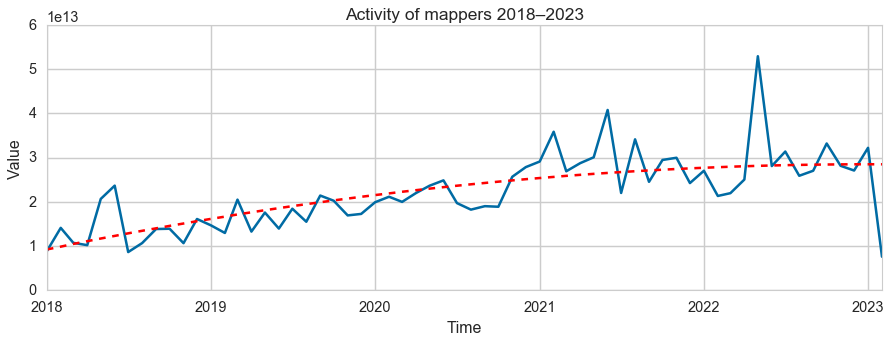

In [ ]:

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 4))



# Plot line plot
ax.plot(df_temp.index, df_temp['count_u_id'])

# Fit trend line using polyfit
trend = np.polyfit(range(len(df_temp.index)), df_temp['count_u_id'], 2)

# Add trend line to plot using poly1d
trendline = np.poly1d(trend)
ax.plot(df_temp.index, trendline(range(len(df_temp.index))),
        linestyle='--', color="red")

# Add labels and title to plot
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Activity of mappers 2018–2023')


plt.style.use("seaborn-bright")
plt.show()


# Show plot
#plt.show()


In [ ]:
df_temp

,count_u_id
y_m,
2018-01-01,8832441686076
2018-02-01,14111941464605
2018-03-01,10730379131718
2018-04-01,10203853125815
2018-05-01,20650982579455
...,...
2022-10-01,33169151799535
2022-11-01,28131212584986
2022-12-01,27066786098712


In [ ]:
df.dtypes

y_m           datetime64[ns]
count_u_id             int64
dtype: object

In [ ]:
df

,y_m,count_u_id
time,,
2018-01-01,2018-01-01,8832441686076
2018-02-01,2018-02-01,14111941464605
2018-03-01,2018-03-01,10730379131718
2018-04-01,2018-04-01,10203853125815
2018-05-01,2018-05-01,20650982579455
...,...,...
2022-10-01,2022-10-01,33169151799535
2022-11-01,2022-11-01,28131212584986
2022-12-01,2022-12-01,27066786098712


In [ ]:
df_test = df.select(["user_id", "changeset_timestamp"]).groupBy(["user_id", "changeset_timestamp"]).count()


In [ ]:
df_test.show()

+-------+-------------------+-----+
|user_id|changeset_timestamp|count|
+-------+-------------------+-----+
|3243024|      1534068273000|    1|
|1219027|      1545135911000|    6|
|3298368|      1540062772000|    1|
| 178396|      1542019279000|    6|
|1042763|      1528053013000|    1|
| 226708|      1526637746000|    5|
| 226708|      1525171288000|    1|
|3243024|      1515878968000|    3|
| 226708|      1529760145000|   11|
| 454932|      1514903239000|    1|
|1219027|      1546176334000|    2|
|1219027|      1542637496000|    1|
|1219027|      1545831053000|    5|
|1072008|      1514809558000|    1|
|2179792|      1516026478000|    1|
|1072008|      1523816871000|    1|
|8283500|      1526507222000|    9|
| 226708|      1530200961000|    2|
|  53048|      1542056582000|    2|
|2475974|      1544700506000|    5|
+-------+-------------------+-----+
only showing top 20 rows



In [ ]:
spark.stop()

In [ ]:

@delayed
def load_chunk(path):
    return ParquetFile(path).to_pandas()


df = dd.from_delayed([load_chunk(f) for f in files_location_lst])

df = df.compute()


### Plot by the contrib_type

In [40]:
df_cr = df.filter(df.contrib_type == "CREATED")
df_cr = df_cr\
    .groupby("y_m")\
    .agg(psf.sum("user_id"))\
    .withColumnRenamed("sum(user_id)", "count_u_id")\
    .toPandas()
df_cr.sort_values(by="y_m", inplace=True)

df_del = df.filter(df.contrib_type == "DELETED")
df_del = df_del\
    .groupby("y_m")\
    .agg(psf.sum("user_id"))\
    .withColumnRenamed("sum(user_id)", "count_u_id")\
    .toPandas()
df_del.sort_values(by="y_m", inplace=True)

df_total = df\
    .groupby("y_m")\
    .agg(psf.sum("user_id"))\
    .withColumnRenamed("sum(user_id)", "count_u_id")\
    .toPandas()
df_total.sort_values(by="y_m", inplace=True)


In [60]:
df_cr


,y_m,count_u_id
10,2018-01,3882738053835
3,2018-02,4656107762366
2,2018-03,5551853128620
9,2018-04,5643827912704
4,2018-05,8389099886059
...,...,...
55,2022-10,14608079302865
54,2022-11,11258041953582
60,2022-12,12177523025402
56,2023-01,11937622682562


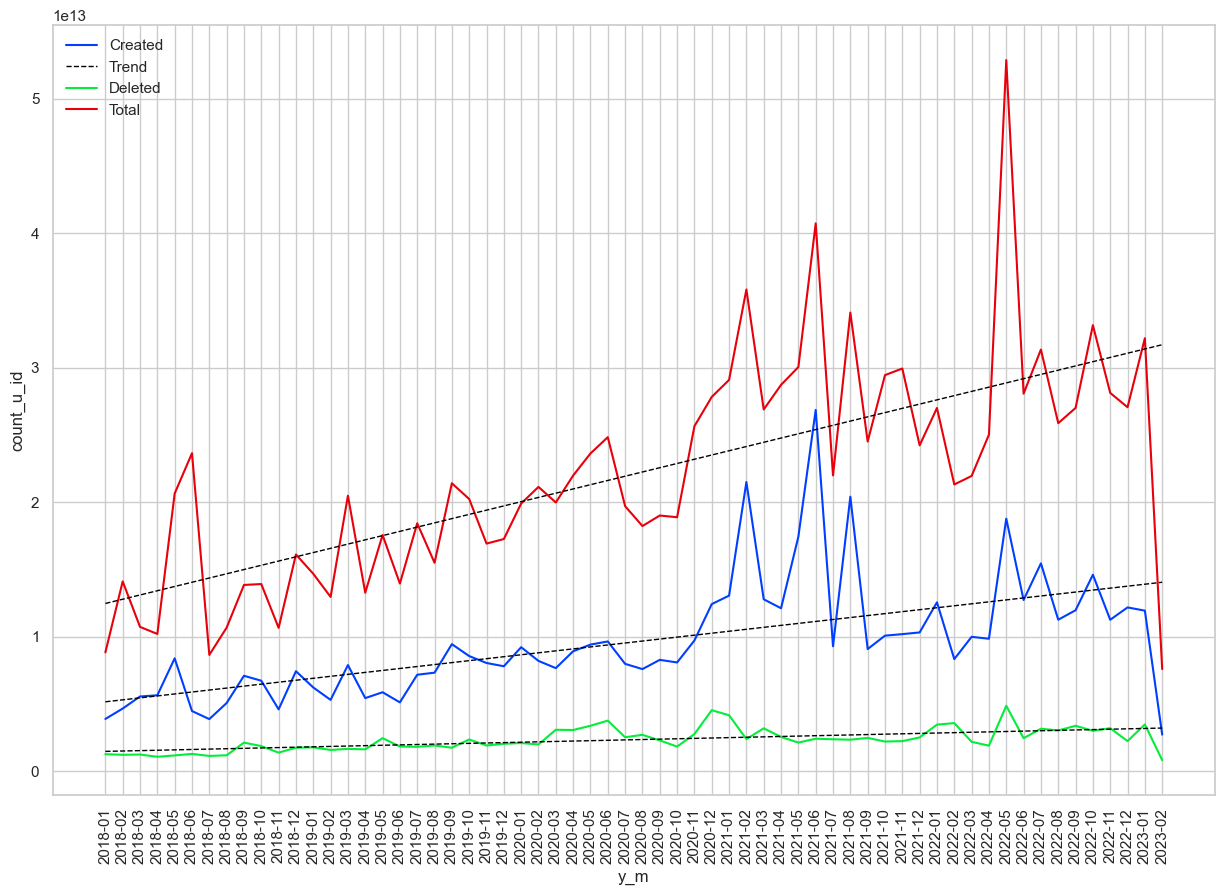

In [74]:
# Lineplot with trends

fig, ax = plt.subplots(figsize = (15, 10))
# plt.style.use("seaborn-bright")


# Line according to contrib_type Created
sns.lineplot(data=df_cr, x="y_m", y="count_u_id", ax=ax, label="Created")
# Fit trend line using polyfit
trend = np.polyfit(range(len(df_cr['y_m'])), df_cr['count_u_id'], 1)
# Add trend line to plot using poly1d
trendline = np.poly1d(trend)
ax.plot(df_cr['y_m'], trendline(range(len(df_cr['y_m']))),
        linestyle='--', color="black", linewidth=1, label="Trend")

# Line according to contrib_type Deleted
sns.lineplot(data=df_del, x="y_m", y="count_u_id", ax=ax, label="Deleted")
# Fit trend line using polyfit
trend = np.polyfit(range(len(df_del['y_m'])), df_del['count_u_id'], 1)
# Add trend line to plot using poly1d
trendline = np.poly1d(trend)
ax.plot(df_del['y_m'], trendline(range(len(df_del['y_m']))),
        linestyle='--', color="black", linewidth=1, )

# Line according to all contrib_type
sns.lineplot(data=df_total, x="y_m", y="count_u_id", ax=ax, label="Total")
# Fit trend line using polyfit
trend = np.polyfit(range(len(df_total['y_m'])), df_total['count_u_id'], 1)
# Add trend line to plot using poly1d
trendline = np.poly1d(trend)
ax.plot(df_cr['y_m'], trendline(range(len(df_cr['y_m']))),
        linestyle='--', color="black", linewidth=1, )


sns.set_style("darkgrid")

plt.xticks(rotation = 90)

ax.legend(loc='upper left', frameon=False)

plt.show()

## Load the all data with DuckDB

In [4]:
# Create a connection to the DuckDB database
con = duckdb.connect(database=f"{duckdb_dir}\\test.db", read_only=False)


In [5]:
table = pq.read_table(test_dir)
con.register('test_table', table)


In [6]:
results = con.execute('SELECT * FROM test_table').fetchall()


In [8]:
len(results)

5629089

In [20]:

# execute a SQL query to get a list of tables in the database
result = con.execute("SELECT name FROM sqlite_master WHERE type='table';")

# fetch the results and convert them to a list
tables = [row[0] for row in result.fetchall()]

print(tables)


[]


In [12]:
dataset = pq.ParquetDataset(
    parquet_dir_node, filesystem=None, partitioning='hive')


In [18]:
type(dataset)


pyarrow.parquet.core._ParquetDatasetV2

In [7]:
# Read Parquet files into a Pandas DataFrame
dataset = pq.ParquetDataset(
    test_dir, filesystem=None, partitioning='hive')
table = dataset.read()


In [8]:
# Convert the PyArrow Table to a DuckDB table
con.from_arrow_table(table, 'test_table')


AttributeError: 'duckdb.DuckDBPyConnection' object has no attribute 'from_arrow_table'

In [11]:
parquet_dir_node


'c:\\Users\\milan\\OneDrive - MUNI\\VŠ\\PhD\\Zahraniční stáž\\Work\\HeiGIT_notebooks\\analysis\\oshdb-contributions-parquet-data\\type=node'

In [12]:
con.close()